Initial Voronoi (fixed seeds only): min_cell_area=0.03, min_pair_dist=0.1, min_boundary_dist=0.1
Voronoi cell areas:
  F_1: 0.0535
  F_2: 0.0844
  F_3: 0.134
  F_4: 0.0501
  F_5: 0.341
  F_6: 0.185


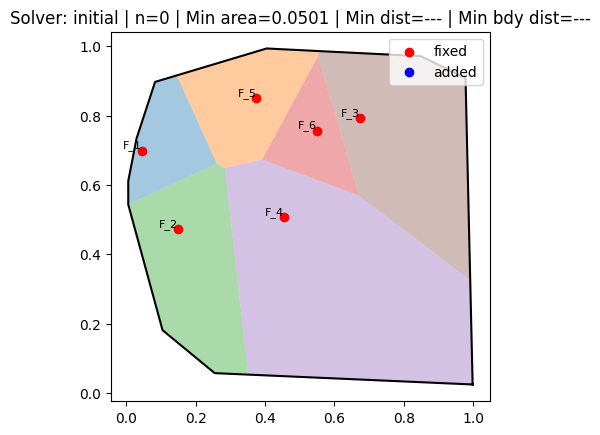


Solver: de_scipy_solver
n=1 is feasible; plotting.
Voronoi cell areas:
  F_1: 0.0535
  F_2: 0.0857
  F_3: 0.0844
  F_4: 0.202
  F_5: 0.187
  F_6: 0.0501
  A_1: 0.185


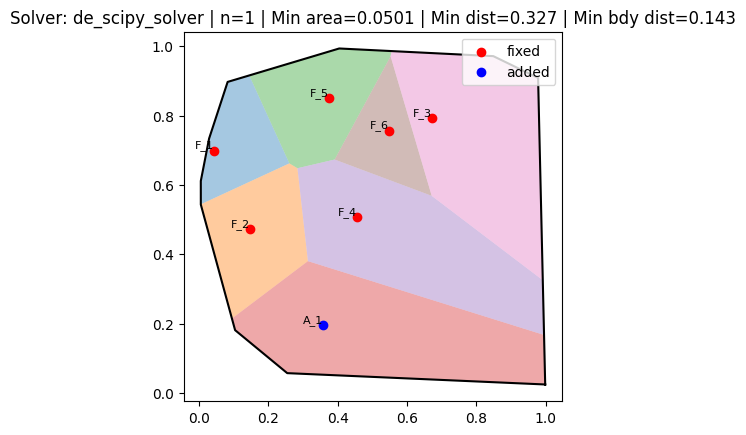

n=2 is feasible; plotting.
Voronoi cell areas:
  F_1: 0.0535
  F_2: 0.0844
  F_3: 0.271
  F_4: 0.13
  F_5: 0.0501
  F_6: 0.0958
  A_1: 0.0684
  A_2: 0.0943


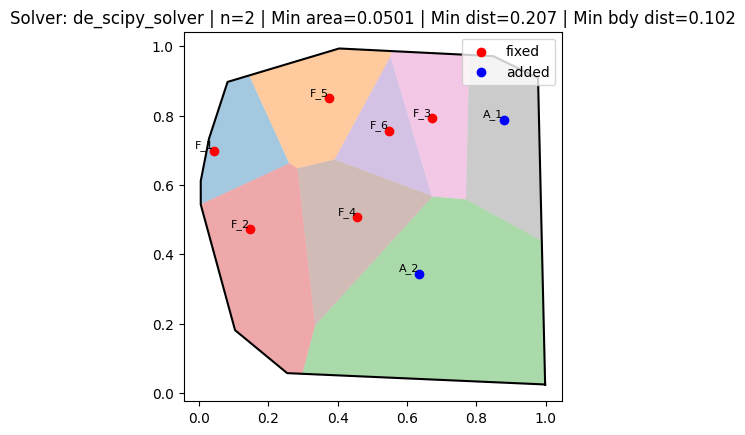

n=4 is feasible; plotting.
Voronoi cell areas:
  F_1: 0.0535
  F_2: 0.0555
  F_3: 0.0844
  F_4: 0.078
  F_5: 0.0656
  F_6: 0.0725
  A_1: 0.0501
  A_2: 0.0687
  A_3: 0.16
  A_4: 0.159


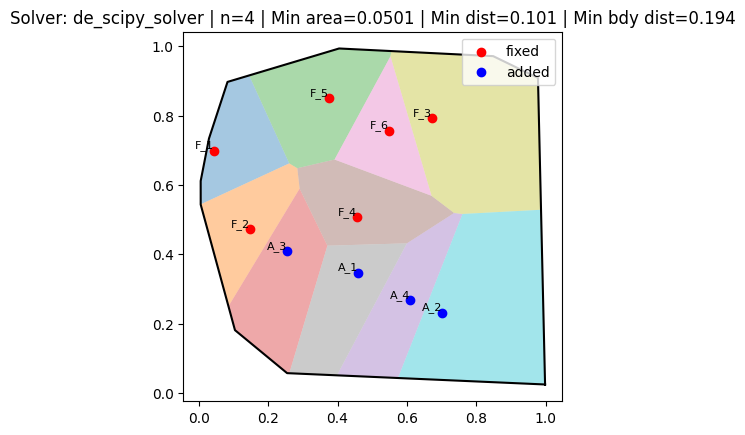

n=8 is feasible; plotting.
Voronoi cell areas:
  F_1: 0.0473
  F_2: 0.0555
  F_3: 0.0513
  F_4: 0.0547
  F_5: 0.0529
  F_6: 0.0725
  A_1: 0.0548
  A_2: 0.0426
  A_3: 0.0492
  A_4: 0.0862
  A_5: 0.104
  A_6: 0.0856
  A_7: 0.0553
  A_8: 0.0356


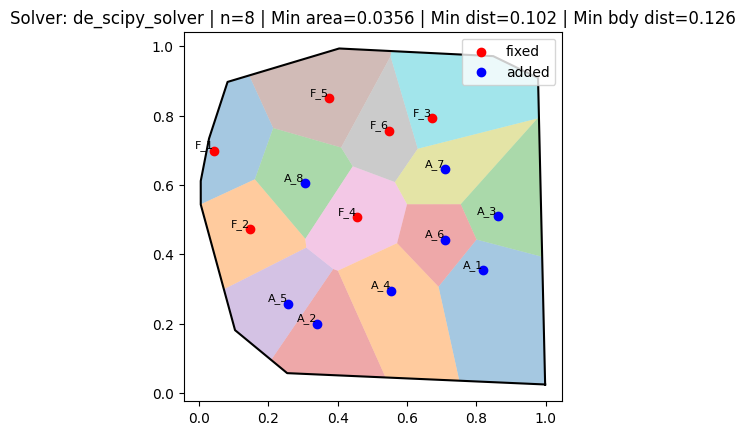

In [ ]:
"""
Script to find the maximum number of additional seed points that can be placed
inside a random convex polygon while satisfying Voronoi-based feasibility
constraints (minimum cell area, minimum pairwise distance, and minimum
distance from the polygon boundary).
"""

from random_polygon import generate_random_convex_polygon_with_fixed
from losses import loss_type_2
from find_max_additional import find_max_additional
from plot_voronoi import plot_voronoi

# ─── 1) Reproducibility and initial fixed seeds ───────────────────────────────
SEED = 43                 # Seed for random polygon and solver initialization
HULL_SAMPLE_COUNT = 50    # Number of random points used to construct the convex hull
NUM_FIXED_SEEDS = 6       # Number of pre-existing interior seed points

# Generate a random convex polygon and a set of fixed interior seed points
polygon, fixed_seeds = generate_random_convex_polygon_with_fixed(
    rand_seed=SEED,
    convexhull_param=HULL_SAMPLE_COUNT,
    num_fixed=NUM_FIXED_SEEDS
)

# ─── 2) Feasibility thresholds ────────────────────────────────────────────────
MIN_CELL_AREA    = 0.03   # Minimum allowed area for each Voronoi cell
MIN_PAIR_DIST    = 0.10   # Minimum allowed Euclidean distance between any two added points
MIN_BOUNDARY_DIST = 0.10  # Minimum allowed distance from any added point to the polygon boundary

# Plot the initial Voronoi diagram using only the fixed seeds
print(
    f"Initial Voronoi (fixed seeds only): "
    f"min_cell_area={MIN_CELL_AREA}, "
    f"min_pair_dist={MIN_PAIR_DIST}, "
    f"min_boundary_dist={MIN_BOUNDARY_DIST}"
)
plot_voronoi(fixed_seeds, [], polygon, solver="initial")

# ─── 3) Define the optimization problem ───────────────────────────────────────
# The 'loss' function encodes both the L2-distance and boundary-distance constraints.
problem = {
    "fixed": fixed_seeds,
    "polygon": polygon,
    "A_min": MIN_CELL_AREA,
    "l2_min": MIN_PAIR_DIST,
    "d_min": MIN_BOUNDARY_DIST,
    "loss": lambda added: loss_type_2(
        fixed_seeds,
        added,
        polygon,
        MIN_PAIR_DIST,
        MIN_BOUNDARY_DIST
    )
}

# ─── 4) Solver configurations ─────────────────────────────────────────────────
# Shared parameters for all solvers
common_params = {
    "popsize": 40,   # Population size (or swarm size) for evolutionary solvers
    "maxiter": 200,  # Maximum number of iterations (or generations)
    "seed": SEED     # Seed for reproducible runs
}

# Parameters customized per solver
solvers_config = {
    "de_scipy_solver": {
        **common_params
    },
    "ga_deap_solver": {
        **common_params,
        "ngen": 100,   # Number of GA generations
        "sigma": 0.1,  # Gaussian mutation strength
        "indpb": 0.1,  # Probability of mutating each gene
        "cxpb": 0.5,   # Crossover probability
        "mutpb": 0.2   # Mutation probability
    },
    "qpso_pairwise": {
        **common_params,
        "alpha": 0.75  # Constriction factor for QPSO velocity update
    }
}

# ─── 5) Run solvers and report results ────────────────────────────────────────
for solver_name, params in solvers_config.items():
    print(f"\nSolver: {solver_name}")
    # find_max_additional returns (max_number_of_added_points, best_configuration)
    max_count, best_added = find_max_additional(
        problem,
        {"name": solver_name, "params": params},
        plot_each=True  # Plot intermediate placements for each additional point
    )
    print(f"Maximum extra points found: {max_count}")
